In [288]:
import utils; reload(utils)
from utils import *
%matplotlib inline


In [289]:
DATA_DIR = '/home/chicm/data/cervc/orig'
TRAIN_DIR = DATA_DIR+'/train'
TEST_DIR = DATA_DIR + '/test'
VALID_DIR = DATA_DIR + '/valid'
RESULT_DIR = DATA_DIR + '/results'
batch_size = 64

In [290]:
batches = get_batches(TRAIN_DIR, batch_size=batch_size)
val_batches = get_batches(VALID_DIR, batch_size=batch_size, shuffle = False)
(val_classes, trn_classes, val_labels, trn_labels,
    val_filenames, filenames, test_filenames) = get_classes(DATA_DIR+'/')

Found 1330 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 1330 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 512 images belonging to 1 classes.


In [291]:
raw_filenames = ['/'.join(f.split('/')[-2:]) for f in filenames]
raw_test_filenames = ['/'.join(f.split('/')[-2:]) for f in test_filenames]
raw_val_filenames = ['/'.join(f.split('/')[-2:]) for f in val_filenames]
print raw_filenames[:5]
print raw_test_filenames[:5]
print raw_val_filenames[:5]

['Type_1/560.jpg', 'Type_1/416.jpg', 'Type_1/846.jpg', 'Type_1/532.jpg', 'Type_1/1230.jpg']
['unknown/17.jpg', 'unknown/416.jpg', 'unknown/372.jpg', 'unknown/44.jpg', 'unknown/94.jpg']
['Type_1/763.jpg', 'Type_1/1390.jpg', 'Type_1/653.jpg', 'Type_1/645.jpg', 'Type_1/873.jpg']


In [292]:
sizes = [PIL.Image.open(TRAIN_DIR+'/'+f).size for f in filenames]
val_sizes = [PIL.Image.open(VALID_DIR+'/'+f).size for f in val_filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [293]:
print sizes[:5]
print val_sizes[:5]

[(3096, 4128), (2448, 3264), (2448, 3264), (2448, 3264), (3096, 4128)]
[(3096, 4128), (3096, 4128), (3096, 4128), (3120, 4160), (2448, 3264)]


# create validation data

In [5]:
import numpy as np
import os,sys,shutil,glob
def create_validation_data():
    os.chdir(TRAIN_DIR)
    files = glob.glob('*/*.jpg')

    #drivers = sorted(driver2imgs.keys())
    files = np.random.permutation(files)
    print files[:10]

    for i in range(150):
        fn = files[i]
        #print TRAIN_DIR+'/'+fn
        shutil.move(TRAIN_DIR+'/'+fn, VALID_DIR+'/'+fn)
#create_validation_data()

['Type_3/492.jpg' 'Type_2/443.jpg' 'Type_2/1371.jpg' 'Type_2/8.jpg' 'Type_2/279.jpg'
 'Type_2/990.jpg' 'Type_2/647.jpg' 'Type_2/1181.jpg' 'Type_3/1459.jpg' 'Type_3/993.jpg']


## Basic VGG

In [294]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(3)

In [8]:
trn = get_data(TRAIN_DIR)
val = get_data(VALID_DIR)

Found 1330 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [88]:
test = get_data(TEST_DIR)

Found 512 images belonging to 1 classes.


In [10]:
save_array(RESULT_DIR+'/trn.dat', trn)
save_array(RESULT_DIR+'/val.dat', val)
save_array(RESULT_DIR+'/test.dat', test)

In [295]:
trn = load_array(RESULT_DIR+'/trn.dat')
val = load_array(RESULT_DIR+'/val.dat')
test = load_array(RESULT_DIR+'/test.dat')

In [296]:
gen = image.ImageDataGenerator()

In [297]:
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [162]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=10, validation_data=(val, val_labels))

Train on 1330 samples, validate on 150 samples
Epoch 1/10
1330/1330 [==============================] - 11s - loss: 2.7240 - acc: 0.4504 - val_loss: 1.5650 - val_acc: 0.5333

In [15]:
model.save_weights(RESULT_DIR+'/ft1.h5')

## precompute vonv output

In [298]:
model.load_weights(RESULT_DIR+'/ft1.h5')

In [299]:
conv_layers, fc_layers = split_at(model, Convolution2D)

In [300]:
conv_model = Sequential(conv_layers)

In [19]:
conv_feat = conv_model.predict(trn)

In [20]:
conv_val_feat = conv_model.predict(val)

In [21]:
conv_test_feat = conv_model.predict(test)

In [22]:
save_array(RESULT_DIR+'/conv_feat.dat', conv_feat)
save_array(RESULT_DIR+'/conv_val_feat.dat', conv_val_feat)
save_array(RESULT_DIR+'/conv_test_feat.dat', conv_test_feat)

In [301]:
conv_feat = load_array(RESULT_DIR+'/conv_feat.dat')
conv_val_feat = load_array(RESULT_DIR+'/conv_val_feat.dat')
conv_test_feat = load_array(RESULT_DIR+'/conv_test_feat.dat')

## train model

In [302]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(3, activation='softmax')
    ]

In [303]:
p = 0.8

In [304]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [176]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(conv_val_feat, val_labels))

Train on 1330 samples, validate on 150 samples
Epoch 1/3
1330/1330 [==============================] - 0s - loss: 0.1182 - acc: 0.9632 - val_loss: 1.5103 - val_acc: 0.6267
Epoch 2/3
1330/1330 [==============================] - 0s - loss: 0.0942 - acc: 0.9692 - val_loss: 1.6315 - val_acc: 0.6000
Epoch 3/3
1330/1330 [==============================] - 0s - loss: 0.1121 - acc: 0.9639 - val_loss: 1.6826 - val_acc: 0.62

In [180]:
bn_model.optimizer.lr = 1e-4
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))


Train on 1330 samples, validate on 150 samples
Epoch 1/7
1330/1330 [==============================] - 0s - loss: 0.0399 - acc: 0.9865 - val_loss: 2.1303 - val_acc: 0.5933
Epoch 2/7
1330/1330 [==============================] - 0s - loss: 0.0570 - acc: 0.9797 - val_loss: 2.1511 - val_acc: 0.6400
Epoch 3/7
1330/1330 [==============================] - 0s - loss: 0.0623 - acc: 0.9797 - val_loss: 2.1231 - val_acc: 0.62

In [181]:
bn_model.save_weights(RESULT_DIR+'/conv_512_6.h5')

In [305]:
bn_model.load_weights(RESULT_DIR+'/conv_512_6.h5')

In [306]:
bn_model.evaluate(conv_val_feat, val_labels)

 32/150 [=====>........................] - ETA: 0s

[2.0619070275624591, 0.62666666666666671]

## import boundary box

In [307]:
import pandas as pd

In [308]:
t1df = pd.read_csv('/home/chicm/ml/cnnpractices/cervc/Type_1_bbox.tsv', sep=' ', header=None)
t2df = pd.read_csv('/home/chicm/ml/cnnpractices/cervc/Type_2_bbox.tsv', sep=' ', header=None)
t3df = pd.read_csv('/home/chicm/ml/cnnpractices/cervc/Type_3_bbox.tsv', sep=' ', header=None)

In [309]:
t2df.head()

,0,1,2,3,4,5
0,Type_2\1.jpg,1,918,1814,492,411
1,Type_2\100.jpg,1,1116,1057,764,544
2,Type_2\1001.jpg,1,1354,2873,590,742
3,Type_2\1002.jpg,1,720,1109,506,693
4,Type_2\1005.jpg,1,1048,1223,1372,1861


In [310]:

dict1 = {row.tolist()[0].replace('\\', '/'): row.tolist()[2:6] for i,row in t1df.iterrows()}
dict2 = {row.tolist()[0].replace('\\', '/'): row.tolist()[2:6] for i,row in t2df.iterrows()}
dict3 = {row.tolist()[0].replace('\\', '/'): row.tolist()[2:6] for i,row in t3df.iterrows()}

bbdict = dict(dict(dict1.items() + dict2.items()).items() + dict3.items())
print len(bbdict.keys())

print bbdict.keys()[:5]
#print type(dict1.keys())


1466
['Type_2/607.jpg', 'Type_2/990.jpg', 'Type_2/283.jpg', 'Type_1/809.jpg', 'Type_2/1057.jpg']


In [311]:
empty_bbox = [0, 0, 0, 0]
print bbdict.keys()[:5]
print raw_filenames[:5]

['Type_2/607.jpg', 'Type_2/990.jpg', 'Type_2/283.jpg', 'Type_1/809.jpg', 'Type_2/1057.jpg']
['Type_1/560.jpg', 'Type_1/416.jpg', 'Type_1/846.jpg', 'Type_1/532.jpg', 'Type_1/1230.jpg']


In [312]:
count = 0
for f in raw_filenames:
    if not f in bbdict.keys():
        bbdict[f] = empty_bbox
        count+=1
for f in raw_val_filenames:
    if not f in bbdict.keys():
        bbdict[f] = empty_bbox
        count+=1
print count

14


In [313]:
def convert_bb(bb, size):
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    newbb = [0,0,0,0]
    newbb[0] = bb[0]*conv_x
    newbb[1] = bb[1]*conv_y
    newbb[2] = bb[2]*conv_x
    newbb[3] = bb[3]*conv_y
    return newbb

In [314]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[0],bb[1]), bb[2], bb[3], color=color, fill=False, lw=3)
def show_bb(i):
    fn = raw_val_filenames[i]
    print fn
    bb = bbdict[fn]
    print bb
    print val_sizes[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(convert_bb(bb, val_sizes[i])))

Type_2/198.jpg
[1066, 1317, 890, 723]
(3096, 4128)


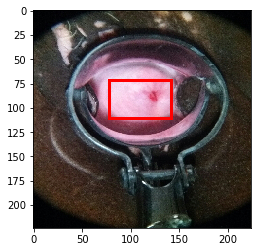

In [315]:
show_bb(100)

In [316]:
trn_bbox = np.stack([convert_bb(bbdict[f], s) for f, s in zip(raw_filenames, sizes)]).astype(np.float32)
print trn_bbox[0]
val_bbox = np.stack([convert_bb(bbdict[f], s) for f, s in zip(raw_val_filenames, val_sizes)]).astype(np.float32)
print val_bbox[0]              

[ 103.0284   84.814    40.3721   44.9845]
[  68.7338  110.9147   99.845    74.8837]


## chop images

In [322]:
import cv2
TGT_DIR = '/home/chicm/data/cervc/origchop'
for f in raw_filenames:
    fn = TRAIN_DIR+'/'+f
    tgt_fn = TGT_DIR+'/train/'+f
    img = cv2.imread(fn)
    bb = bbdict[f]
    if bb[2] > 0 and bb[3] > 0:
        chopimg = img[bb[1]:(bb[1]+bb[3]), bb[0]:(bb[0]+bb[2])]
    else:
        chopimg = img
    cv2.imwrite(tgt_fn, chopimg)

In [323]:
for f in raw_val_filenames:
    fn = VALID_DIR+'/'+f
    tgt_fn = TGT_DIR+'/valid/'+f
    img = cv2.imread(fn)
    bb = bbdict[f]
    if bb[2] > 0 and bb[3] > 0:
        chopimg = img[bb[1]:(bb[1]+bb[3]), bb[0]:(bb[0]+bb[2])]
    else:
        chopimg = img
    cv2.imwrite(tgt_fn, chopimg)

## create and train model

In [223]:
p=0.8

In [238]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(3, activation='softmax', name='class')(x)

In [239]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.01, 1.])

In [251]:
model.optimizer.lr = 1e-3
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 1330 samples, validate on 150 samples
Epoch 1/3
1330/1330 [==============================] - 0s - loss: 3.0915 - bb_loss: 268.6160 - class_loss: 0.4053 - bb_acc: 0.7602 - class_acc: 0.8429 - val_loss: 4.5598 - val_bb_loss: 360.8401 - val_class_loss: 0.9514 - val_bb_acc: 0.6933 - val_class_acc: 0.6133
Epoch 2/3
1330/1330 [==============================] - 0s - loss: 3.1494 - bb_loss: 274.3205 - class_loss: 0.4062 - bb_acc: 0.7383 - class_acc: 0.8308 - val_loss: 4.5598 - val_bb_loss: 360.8322 - val_class_loss: 0.951

In [252]:
model.optimizer.lr = 1e-5

In [261]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 1330 samples, validate on 150 samples
Epoch 1/10
1330/1330 [==============================] - 0s - loss: 1.8876 - bb_loss: 173.8925 - class_loss: 0.1487 - bb_acc: 0.8083 - class_acc: 0.9406 - val_loss: 4.9169 - val_bb_loss: 351.7592 - val_class_loss: 1.3993 - val_bb_acc: 0.7067 - val_class_acc: 0.5933
Epoch 2/10
1330/1330 [==============================] - 0s - loss: 1.7800 - bb_loss: 163.6847 - class_loss: 0.1432 - bb_acc: 0.8188 - class_acc: 0.9489 - val_loss: 4.8502 - val_bb_loss: 348.9121 - val_class_loss: 1.3

In [274]:
pred = model.predict(conv_val_feat[0:100])

In [275]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

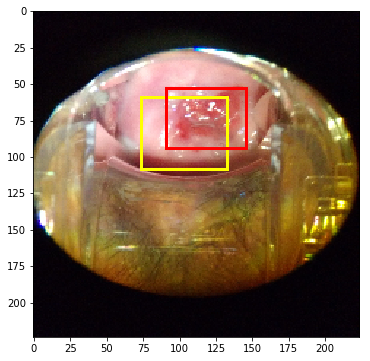

In [287]:
show_bb_pred(21)

In [86]:
pred_test = model.predict(conv_test_feat[0:100])

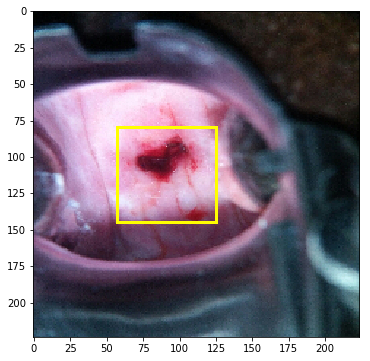

In [105]:
def show_bb_test_pred(i):
    #bb = val_bbox[i]
    bb_pred = pred_test[0][i]
    plt.figure(figsize=(6,6))
    plot(test[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    #ax.add_patch(create_rect(bb))
show_bb_test_pred(54)

In [106]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

 32/150 [=====>........................] - ETA: 0s

[2.9001451174418134,
 359.70760253906252,
 2.5404375108083088,
 0.69999999602635699,
 0.56000000238418579]

In [80]:
model.save_weights(RESULT_DIR+'/bn_anno.h5')

In [81]:
model.load_weights(RESULT_DIR+'/bn_anno.h5')

## Larger size

In [107]:
trn = get_data(TRAIN_DIR, (640,640))
val = get_data(VALID_DIR, (640,640))

Found 1330 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


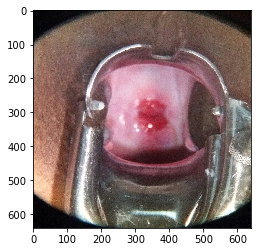

In [108]:
plot(trn[0])

In [109]:
test = get_data(TEST_DIR, (640, 640))

Found 512 images belonging to 1 classes.


In [110]:
save_array(RESULT_DIR+'/trn640.dat', trn)
save_array(RESULT_DIR+'/val640.dat', val)
save_array(RESULT_DIR+'/test640.dat', test)

In [111]:
trn = load_array(RESULT_DIR+'/trn640.dat')
val = load_array(RESULT_DIR+'/val640.dat')
test = load_array(RESULT_DIR+'/test640.dat')

# create vgg model

In [115]:
vgg640 = Vgg16BN((640,640)).model
vgg640.pop()
print vgg640.input_shape 
print vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

(None, 3, 640, 640)
(None, 512, 40, 40)


In [121]:
conv_trn_feat = vgg640.predict(trn, batch_size=8, verbose=1)
conv_val_feat = vgg640.predict(val, batch_size=8, verbose=1)
conv_test_feat = vgg640.predict(test, batch_size=8, verbose=1)

512/512 [==============================] - 43s     

In [122]:
save_array(RESULT_DIR+'/conv_trn_640.dat', conv_trn_feat)
save_array(RESULT_DIR+'/conv_val_640.dat', conv_val_feat)
save_array(RESULT_DIR+'/conv_test_640.dat', conv_test_feat)

In [123]:
conv_trn_feat = load_array(RESULT_DIR+'/conv_trn_640.dat')
conv_val_feat = load_array(RESULT_DIR+'/conv_val_640.dat')
conv_test_feat = load_array(RESULT_DIR+'/conv_test_640.dat')

## fully convolutional net

In [124]:
conv_layers,_ = split_at(vgg640, Convolution2D)

In [125]:
nf=128; p=0.

In [126]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(3,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [127]:
lrg_model = Sequential(get_lrg_layers())

In [128]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_12 (BatchNorm (None, 512, 40, 40)   2048        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_66 (Convolution2D) (None, 128, 40, 40)   589952      batchnormalization_12[0][0]      
____________________________________________________________________________________________________
batchnormalization_13 (BatchNorm (None, 128, 40, 40)   512         convolution2d_66[0][0]           
____________________________________________________________________________________________________
maxpooling2d_29 (MaxPooling2D)   (None, 128, 20, 20)   0           batchnormalization_13[0][0]      
___________________________________________________________________________________________

In [129]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [132]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 1330 samples, validate on 150 samples
Epoch 1/2
1330/1330 [==============================] - 3s - loss: 0.0864 - acc: 0.9850 - val_loss: 1.0705 - val_acc: 0.4200

In [133]:
lrg_model.optimizer.lr=1e-5

In [134]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 1330 samples, validate on 150 samples
Epoch 1/6
1330/1330 [==============================] - 3s - loss: 0.0378 - acc: 0.9940 - val_loss: 1.0233 - val_acc: 0.5867

In [135]:
lrg_model.save_weights(RESULT_DIR+'/lrg_0mp.h5')

In [136]:
lrg_model.load_weights(RESULT_DIR+'/lrg_0mp.h5')

## create heatmap

In [137]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

In [138]:
def get_cm2(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (640,640))

In [139]:
inp = np.expand_dims(conv_val_feat[0], 0)

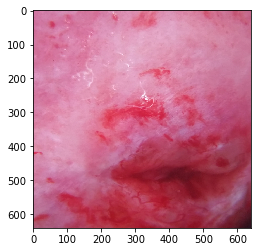

In [146]:
plt.imshow(to_plot(val[1]))

In [147]:
cm = get_cm2(inp, 0)

In [148]:
cm = get_cm2(inp, 2)

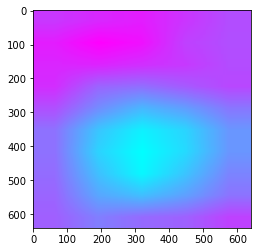

In [149]:
plt.imshow(cm, cmap="cool")

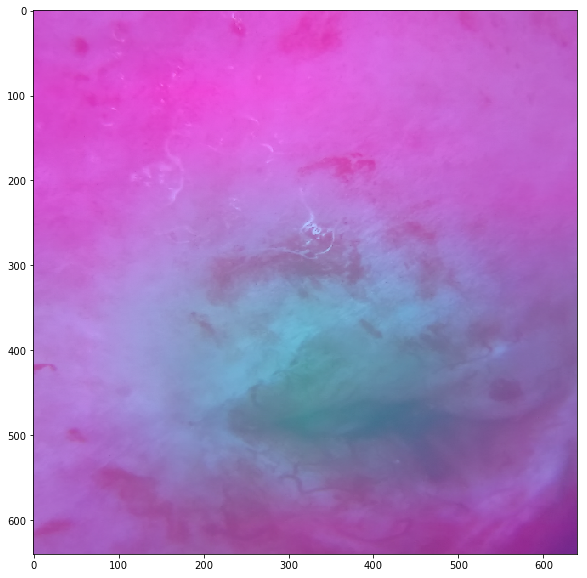

In [151]:
plt.figure(figsize=(10,10))
plot(val[1])
plt.imshow(cm, cmap="cool", alpha=0.5)